## Is it a guinea pig, a hamster or something else?

fork from https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
try:
    import google.colab
    isColab = True
except:
    isColab = False

if iskaggle:
    !pip install fastai duckduckgo_search

if isColab:
    !pip install -Uqq fastai
    !pip install -Uqq duckduckgo_search

## Step 1: Download images of guinea pigs, hamsters and other rodents

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "guinea pig", "hamster" and "rat" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [4]:
rodents = 'chinchilla','gerbil','guinea pig','hamster','mouse','octodon','rat','squirrel', 'not-a-rodent'
path = Path('rodents')
from time import sleep
from fastai.vision.all import *

def download_images_and_sleep(dest, term, sleep_time=10):
    download_images(dest, urls=search_images(term))
    sleep(10)

for output_value in rodents:
    search_term = output_value
    if (output_value == 'not-a-rodent'):
        search_term = 'cat'
    dest = (path/output_value)
    dest.mkdir(exist_ok=True, parents=True)
    download_images_and_sleep(dest, f'{search_term} photo')
    download_images_and_sleep(dest, f'{search_term} sun photo')
    download_images_and_sleep(dest, f'{search_term} shade photo')
    resize_images(path/output_value, max_size=400, dest=path/output_value)

/home/vincent/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Searching for 'chinchilla photo'
Searching for 'chinchilla sun photo'
Searching for 'chinchilla shade photo'
Searching for 'gerbil photo'
Searching for 'gerbil sun photo'
Searching for 'gerbil shade photo'
Searching for 'guinea pig photo'
Searching for 'guinea pig sun photo'
Searching for 'guinea pig shade photo'
Searching for 'hamster photo'
Searching for 'hamster sun photo'
Searching for 'hamster shade photo'
Searching for 'mouse photo'
Searching for 'mouse sun photo'
Searching for 'mouse shade photo'
Searching for 'octodon photo'
Searching for 'octodon sun photo'
Searching for 'octodon shade photo'
Searching for 'rat photo'
Searching for 'rat sun photo'
Searching for 'rat shade photo'
Searching for 'squirrel photo'
Searching for 'squirrel sun photo'
Searching for 'squirrel shade photo'
Searching for 'cat photo'
Searching for 'cat sun photo'
Searching for 'cat shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

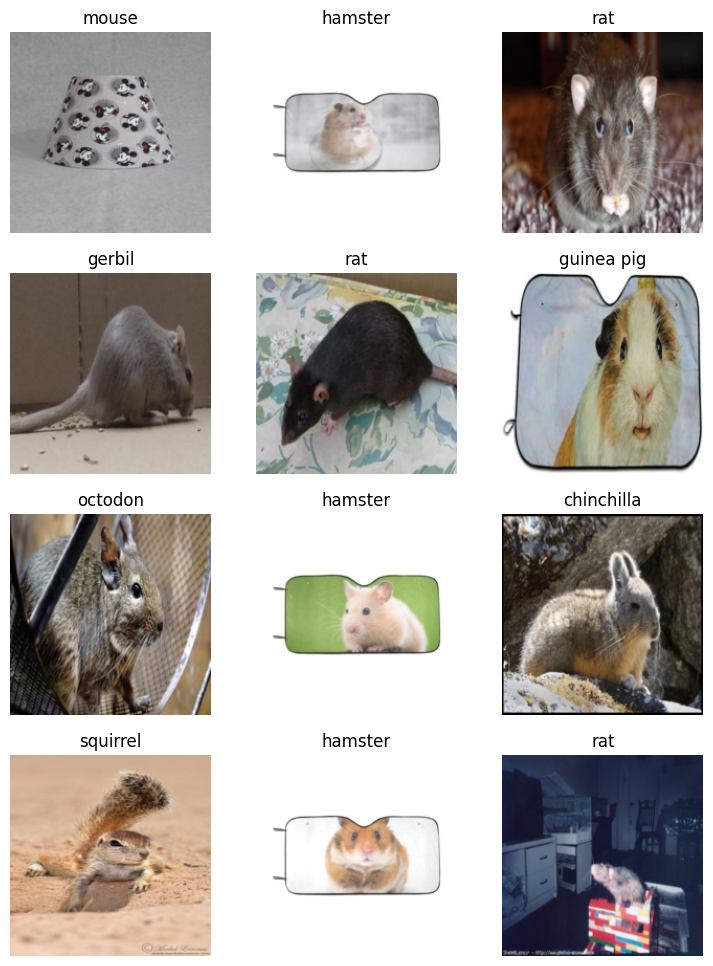

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12, nrows=4)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/home/vincent/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/vincent/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.613456,0.666926,0.201117,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.572259,0.393724,0.108007,02:01
1,0.360847,0.346789,0.104283,01:56
2,0.227314,0.338414,0.096834,01:55
3,0.147360,0.321972,0.104283,01:54
4,0.095069,0.341164,0.106145,02:01
5,0.075612,0.344519,0.109870,01:53


## Step 3: Use our model (and build your own!)

download a guinea pig image and see if our model can predict it:

In [11]:
from fastdownload import download_url
# for each item of rodents list except the last one, download a photo of that rodent and predict what it is

categories = learn.dls.vocab
print(f'Catgories: {categories}')
for item in rodents[:-1]:
	urls=search_images(f'{item} photo', max_images=1)
	dest = f'{item}.jpg'
	download_url(urls[0], dest, show_progress=False)
	im = Image.open(dest)
	im.to_thumb(256,256)
	img = PILImage.create(dest)
	predicted,_,probs = learn.predict(img)
	print(f'Predicted: {predicted}')
	# get index for probs item with the highest probability
	max_index = probs.argmax()
	print(f'Probability: {probs[max_index]:.04f}')
	if (predicted != rodents[max_index-1]):
		print('predicted field not matching probs max probability!')
	for i in range(len(rodents)):
		index_prob = i + 1
		print(f'{i} {rodents[i]}: {probs[index_prob]:.04f}')
	print(f'Probs: {probs}')

Catgories: ['cat', 'chinchilla', 'gerbil', 'guinea pig', 'hamster', 'mouse', 'not-a-rodent', 'octodon', 'rat', 'squirrel']
Searching for 'chinchilla photo'


Predicted: chinchilla
Probability: 0.9999
0 chinchilla: 0.9999
1 gerbil: 0.0000
2 guinea pig: 0.0000
3 hamster: 0.0000
4 mouse: 0.0000
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([5.6228e-05, 9.9988e-01, 1.4355e-06, 6.2119e-07, 4.1521e-06,
            2.8502e-06, 3.3916e-05, 9.1570e-06, 8.3734e-07, 9.5377e-06])
Searching for 'gerbil photo'


Predicted: gerbil
Probability: 1.0000
0 chinchilla: 0.0000
1 gerbil: 1.0000
2 guinea pig: 0.0000
3 hamster: 0.0000
4 mouse: 0.0000
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([7.4606e-09, 3.9898e-07, 1.0000e+00, 1.6040e-08, 9.6896e-08,
            5.2730e-07, 2.5379e-08, 1.7111e-07, 2.2597e-07, 2.1473e-08])
Searching for 'guinea pig photo'


Predicted: guinea pig
Probability: 1.0000
0 chinchilla: 0.0000
1 gerbil: 0.0000
2 guinea pig: 1.0000
3 hamster: 0.0000
4 mouse: 0.0000
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([1.6305e-08, 1.1153e-10, 4.9785e-07, 1.0000e+00, 1.4050e-07,
            1.0969e-08, 4.2658e-08, 4.9892e-10, 8.1474e-08, 1.1650e-08])
Searching for 'hamster photo'


Predicted: hamster
Probability: 1.0000
0 chinchilla: 0.0000
1 gerbil: 0.0000
2 guinea pig: 0.0000
3 hamster: 1.0000
4 mouse: 0.0000
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([1.9210e-10, 1.7632e-11, 5.0724e-10, 1.5935e-10, 1.0000e+00,
            4.5134e-09, 1.8328e-10, 4.7310e-12, 3.7306e-08, 1.5068e-11])
Searching for 'mouse photo'


Predicted: mouse
Probability: 0.9994
0 chinchilla: 0.0000
1 gerbil: 0.0000
2 guinea pig: 0.0000
3 hamster: 0.0004
4 mouse: 0.9994
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([8.5300e-05, 8.7339e-08, 3.0625e-05, 6.9385e-06, 3.6982e-04,
            9.9945e-01, 2.6931e-06, 1.1487e-05, 2.5141e-05, 1.9945e-05])
Searching for 'octodon photo'


Predicted: octodon
Probability: 1.0000
predicted field not matching probs max probability!
0 chinchilla: 0.0000
1 gerbil: 0.0000
2 guinea pig: 0.0000
3 hamster: 0.0000
4 mouse: 0.0000
5 octodon: 0.0000
6 rat: 1.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.0000
Probs: TensorBase([1.3953e-06, 2.6345e-06, 2.3155e-06, 6.0281e-06, 4.9068e-09,
            6.7446e-07, 1.2267e-06, 9.9998e-01, 1.8598e-07, 3.6647e-06])
Searching for 'rat photo'


Predicted: rat
Probability: 0.9990
predicted field not matching probs max probability!
0 chinchilla: 0.0000
1 gerbil: 0.0005
2 guinea pig: 0.0000
3 hamster: 0.0000
4 mouse: 0.0004
5 octodon: 0.0000
6 rat: 0.0000
7 squirrel: 0.9990
8 not-a-rodent: 0.0000
Probs: TensorBase([4.6523e-05, 2.7326e-06, 4.9430e-04, 1.5371e-06, 4.1238e-05,
            3.5163e-04, 2.6609e-05, 1.0353e-05, 9.9902e-01, 4.3287e-06])
Searching for 'squirrel photo'


Predicted: squirrel
Probability: 0.9998
predicted field not matching probs max probability!
0 chinchilla: 0.0000
1 gerbil: 0.0000
2 guinea pig: 0.0000
3 hamster: 0.0000
4 mouse: 0.0000
5 octodon: 0.0001
6 rat: 0.0000
7 squirrel: 0.0000
8 not-a-rodent: 0.9998
Probs: TensorBase([1.5043e-04, 7.7559e-06, 5.9538e-08, 3.8974e-07, 3.7652e-08,
            6.6965e-07, 6.3120e-05, 1.2089e-06, 1.0659e-08, 9.9978e-01])


In [9]:
doc(vision_learner)

vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, loss_func=None, opt_func=<function Adam at 0x7f32831a7130>, lr=0.001, splitter=None, cbs=None, metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95, 0.85, 0.95), cut=None, init=<function kaiming_normal_ at 0x7f32e896dab0>, custom_head=None, concat_pool=True, pool=True, lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, *, n_in=3)
Build a vision learner from `dls` and `arch`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [10]:
??vision_learner

Signature:
vision_learner(
    dls,
    arch,
    normalize=True,
    n_out=None,
    pretrained=True,
    loss_func=None,
    opt_func=<function Adam at 0x7f32831a7130>,
    lr=0.001,
    splitter=None,
    cbs=None,
    metrics=None,
    path=None,
    model_dir='models',
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    cut=None,
    init=<function kaiming_normal_ at 0x7f32e896dab0>,
    custom_head=None,
    concat_pool=True,
    pool=True,
    lin_ftrs=None,
    ps=0.5,
    first_bn=True,
    bn_final=False,
    lin_first=False,
    y_range=None,
    *,
    n_in=3,
)
Source:   
@delegates(create_vision_model)
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, 
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
        # model & head args
        cut=None